In [58]:
# Requirement: Python3 지식
#              수업시간에 배운 딥러닝 기술
#              약간의 OS 지식
#              약간의 응용력

print('Hello world')

import torch

print('Device id: ', torch.cuda.current_device())
print('Available: ', torch.cuda.is_available())
print('Property: ', torch.cuda.get_device_properties(0))

Hello world
Device id:  0
Available:  True
Property:  _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


# Dataset Upload Module

In [59]:
'''
# Google drive dataset이 업로드가 되어있지 않을 경우
# 섹션이 재시작 될 때 마다 재 업로드가 필요
from google.colab import files

# File upload
uploaded = files.upload()
uploaded.keys()
'''

'\n# Google drive dataset이 업로드가 되어있지 않을 경우\n# 섹션이 재시작 될 때 마다 재 업로드가 필요\nfrom google.colab import files\n\n# File upload\nuploaded = files.upload()\nuploaded.keys()\n'

In [60]:
# Setup 1. Connect Google Drive
# Google Drive Dataset이 업로드가 되어있는 경우
# 섹션 재시작시에도 빠르게 복구 가능 
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# Setup 2. extract zip: Please download dataset [cat_dog_dataset.zip]
import zipfile
file_path = '/content/drive/My Drive/2020_1학기/멀티미디어/dog_cat_dataset.zip'
!cp "{file_path}" "./"

In [62]:
import os
# Setup 3. unzip and check
!unzip -q -o dog_cat_dataset.zip

print(len(os.listdir('./train')))
print(len(os.listdir('./val')))
print(len(os.listdir('./test')))

20000
2500
2500


# Learn Pytorch!!

In [63]:
import torch
x = torch.rand(5,3)
print(x)
print(x.shape, x.dim())

x = torch.rand(1, requires_grad=True)
y = x * 3 + 5
y.backward()
print(x.grad)

tensor([[0.1037, 0.0640, 0.0709],
        [0.9971, 0.3923, 0.8640],
        [0.5462, 0.2779, 0.4872],
        [0.0688, 0.3582, 0.8589],
        [0.3287, 0.0882, 0.7282]])
torch.Size([5, 3]) 2
tensor([3.])


# Network Data Loader

torch.Size([4, 3, 64, 64])
torch.Size([4])


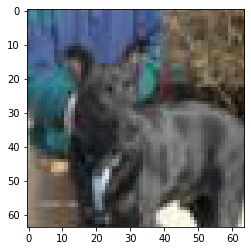

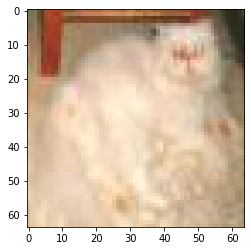

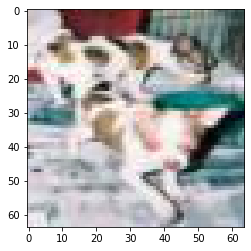

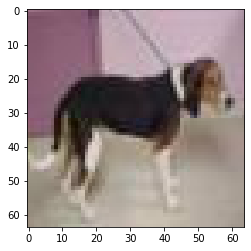

In [64]:
import torch
import torch.utils.data as data
import os
import matplotlib.pyplot as plt

#---------------------------------
import torch.utils.data as data 
#---------------------------------

CLASS_MAPPING = ['CAT', 'DOG']

class ImageLoader(data.Dataset):
  def __init__(self, root_path):
    super(ImageLoader, self).__init__()

    self.root_path = root_path
    self.examples = os.listdir(self.root_path)

  def __len__(self):
    return len(self.examples)

  def __getitem__(self, idx):
    # read image
    img = plt.imread(self.root_path + '/' + self.examples[idx]) / 255. # NUMPY_ARRAY

    # CAT? DOG? 미리 판단 
    name = self.examples[idx].split('_')[0]
    if name == 'cat':
      label = 0 # CAT
    else:
      label = 1 # DOG
    
    # numpy: Numpy array[H x W x C]
    # torch: Tensor[C x H x W]
    img = img.transpose((2,0,1)) 

    return img, label

train_root = './train'
test_root = './test'
validation_root = './val'

train_examples = ImageLoader(train_root)
validation_examples = ImageLoader(validation_root)
test_examples = ImageLoader(test_root)

#mini-batch 단위로 data load 
train_dataloader = data.DataLoader(train_examples, batch_size=4, shuffle=False)
validation_dataloader = data.DataLoader(validation_examples, batch_size=4, shuffle=False)
test_dataloader = data.DataLoader(test_examples, batch_size=4, shuffle=False)


train_minibatches = iter(train_dataloader)
imgs, labels = train_minibatches.next()
print(imgs.shape)
print(labels.shape)

#같은역할인데 이름이 다름. 
# Numpy, tensorflow, matlab: transpose 
# pytorch: permute
for img_idx in range(len(imgs)):
  plt.imshow(imgs[img_idx].permute(1,2,0))
  plt.show()


In [65]:
print(len(train_examples))
print(len(validation_examples))
print(len(test_examples))

img, label=train_examples[5]
#img=plt.imread(train_root+'/'+train_examples[12]) #위에서 data import 해서 이렇게 할필요 없음. 
print(img.shape)
plt.show()

20000
2500
2500
(3, 64, 64)


# Network Construction

In [66]:
import torch
import torch.nn.functional as F #for Relu
import torch.nn as nn

#Pytorch에서 제공하는 모듈화 작업. 
class ClassificationModel(nn.Module):
  def __init__(self):
    super(ClassificationModel, self).__init__()

    #Defnie Convolution Operation
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1) 
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #stride/pooling으로 이미지 크기를 조정하는 효과
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.linear = nn.Linear(16*16*64, 1)

  def forward(self, x):
    # run 'Operation': 마치 함수 처럼 사용 가능. 32부터 시작해서 2배씩 증가.(1:09)
    x = F.relu(self.conv1(x)) # INPUT [1, 3, 64, 64] -> OUTPUT [1, 32, 64, 64]
    x = self.pool1(x) # INPUT [1, 32, 64, 64] -> OUTPUT [1, 32, 32, 32]
    x = F.relu(self.conv2(x)) # INPUT [1, 32, 32, 32] -> OUTPUT [1, 64, 32, 32]
    x = self.pool2(x) # INPUT [1, 64, 32, 32] -> OUTPUT [1, 64, 16, 16]
    x = x.view(-1, 16*16*64) # INPUT [1, 64, 16, 16] -> OUTPUT [1, 64*16*16]  #input텐서를 지정된 output텐서로 펴주는 과정.16384로.
    x = torch.sigmoid(self.linear(x)) # INPUT [1, 64*16*16] -> OUTPUT [1, 1]
    return x

net = ClassificationModel()
x = torch.rand(1, 3, 64, 64) # Dummy input [BATCH, CHANNEL, HEIGJHT ,WIDTH]
print(x.shape)
output = net(x)

print('input shape: ', x.shape, 'output shape: ', output.shape)

print([name for name, width in net.named_parameters()])
print(net.state_dict().keys()) #dict로 바꾸면 나중에 유리?(1:18)

torch.Size([1, 3, 64, 64])
input shape:  torch.Size([1, 3, 64, 64]) output shape:  torch.Size([1, 1])
['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear.weight', 'linear.bias']
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'linear.weight', 'linear.bias'])


# Network Training



In [67]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import os
from tqdm.notebook import tqdm # for visualize training step. iterative한 것의 진행도를 보여줌. 트레이닝 정도를 시각화. 

net = ClassificationModel().cuda() # GPGPU
criterion = nn.BCELoss() # Binary Cross Entropy
optimizer = torch.optim.Adam(net.parameters(), lr=0.001) # Adam Optimizer

object_epoch = 10

train_info = []
validation_info = []

save_path = './ClassificationNetwork/'
os.makedirs(save_path, exist_ok=True) # make folder

print('Training Start!!!!')

#train_1epoch()와 똑같이 복사해서 트레이닝 관련 부분만 지워주면 됨. 
def inference_1epoch(dataloader):
  confusion_matrix = [[0,0],[0,0]] # Confusion Matrix for accuracy calculation
  total_loss = 0 # 1 epoch loss
  iteration = 0  # iteration number 

  net.eval() # Inference mode
  
  for sample in tqdm(dataloader):
    imgs, labels = sample
    imgs = imgs.float().cuda()
    labels = labels.float().cuda()

    optimizer.zero_grad()
    outputs = net(imgs).squeeze(1) # [BATCH, 1] -> [BATCH]
    loss = criterion(outputs, labels)
    # loss.backward() # Inference 과정에서는 필요 없음
    # optimizer.step() # 한번의 가중치 업데이트(Stocastic Gradient Decendent)

    # detach(): Tensor 기울기 계산 그래프에서 제거
    # cpu()   : GPU memory에 있는 정보를 CPU로 전환
    total_loss += loss.detach().cpu()
    iteration += 1

    for i in range(len(labels)):
      real_class = int(labels[i])
      pred_class = int(outputs[i]>0.5)
      confusion_matrix[real_class][pred_class] += 1

  positive = confusion_matrix[0][0] + confusion_matrix[1][1]
  negative = confusion_matrix[1][0] + confusion_matrix[0][1]
  accuracy = positive / (positive + negative)
  total_loss = total_loss/iteration
  
  return accuracy, total_loss

def train_1epoch(dataloader):
  confusion_matrix = [[0,0],[0,0]] # Confusion Matrix for accuracy calculation
  total_loss = 0 # 1 epoch loss
  iteration = 0  # iteration number 

  net.train() # training mode
  
  for sample in tqdm(dataloader):
    imgs, labels = sample
    imgs = imgs.float().cuda()
    labels = labels.float().cuda()

    optimizer.zero_grad()
    outputs = net(imgs).squeeze(1) # [BATCH, 1] -> [BATCH]
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step() # 한번의 가중치 업데이트(Stocastic Gradient Decendent)

    # detach(): Tensor 기울기 계산 그래프에서 제거
    # cpu()   : GPU memory에 있는 정보를 CPU로 전환
    total_loss += loss.detach().cpu()
    iteration += 1

    for i in range(len(labels)):
      real_class = int(labels[i])
      pred_class = int(outputs[i]>0.5)
      confusion_matrix[real_class][pred_class] += 1
  #트레이닝 결과로 정확도 계산(accuracy)
  positive = confusion_matrix[0][0] + confusion_matrix[1][1]
  negative = confusion_matrix[1][0] + confusion_matrix[0][1]
  accuracy = positive / (positive + negative)
  total_loss = total_loss/iteration
  
  return accuracy, total_loss


best_accuracy = 0
for epoch in range(object_epoch):
  # Training 1 epoch
  print('Training start epoch {}'.format(epoch))
  accuracy, loss = train_1epoch(train_dataloader)
  train_info.append({'loss':loss, 'accuracy':accuracy}) #딕셔너리 정보.(중괄호) 
  print('[Training] EPOCH {} finish. accuracy: {}, loss: {}'.format(epoch, accuracy, loss))

  # Validation 1 Epoch
  print('validation start Epoch {}'.format(epoch))
  with torch.no_grad():
    accuracy, loss = inference_1epoch(validation_dataloader)
  
  # Model Save
  if best_accuracy < accuracy:
    best_accuracy = accuracy
    torch.save({
        'memo': 'Classification Model!!!',
        'accuracy': accuracy,
        'model_weight': net.state_dict()
    }, save_path + '/best_model.tar') #세이브파일 경로. tar는 pytorch 체크포인트 지정하기 위한 포맷.

  validation_info.append({'loss':loss, 'accuracy':accuracy})
  print('[VALIDATION] EPOCH {} finish. accuracy: {}, loss: {}'.format(epoch, accuracy, loss))
  print('-------------------------------------------------')
print('FINISH!!!')

Training Start!!!!
Training start epoch 0



[Training] EPOCH 0 finish. accuracy: 0.62635, loss: 0.6392852067947388
validation start Epoch 0



[VALIDATION] EPOCH 0 finish. accuracy: 0.694, loss: 0.5829257369041443
-------------------------------------------------
Training start epoch 1



[Training] EPOCH 1 finish. accuracy: 0.7196, loss: 0.5524301528930664
validation start Epoch 1



[VALIDATION] EPOCH 1 finish. accuracy: 0.7156, loss: 0.5477511286735535
-------------------------------------------------
Training start epoch 2



[Training] EPOCH 2 finish. accuracy: 0.74455, loss: 0.519648551940918
validation start Epoch 2



[VALIDATION] EPOCH 2 finish. accuracy: 0.742, loss: 0.5302313566207886
-------------------------------------------------
Training start epoch 3



[Training] EPOCH 3 finish. accuracy: 0.7614, loss: 0.497112900018692
validation start Epoch 3



[VALIDATION] EPOCH 3 finish. accuracy: 0.7408, loss: 0.5246307849884033
-------------------------------------------------
Training start epoch 4



[Training] EPOCH 4 finish. accuracy: 0.77425, loss: 0.47855105996131897
validation start Epoch 4



[VALIDATION] EPOCH 4 finish. accuracy: 0.7416, loss: 0.5220215320587158
-------------------------------------------------
Training start epoch 5



[Training] EPOCH 5 finish. accuracy: 0.7843, loss: 0.4595341682434082
validation start Epoch 5



[VALIDATION] EPOCH 5 finish. accuracy: 0.7384, loss: 0.5347456932067871
-------------------------------------------------
Training start epoch 6



[Training] EPOCH 6 finish. accuracy: 0.7967, loss: 0.4420682191848755
validation start Epoch 6



[VALIDATION] EPOCH 6 finish. accuracy: 0.7324, loss: 0.5455018281936646
-------------------------------------------------
Training start epoch 7



[Training] EPOCH 7 finish. accuracy: 0.80525, loss: 0.428284227848053
validation start Epoch 7



[VALIDATION] EPOCH 7 finish. accuracy: 0.7368, loss: 0.5489854216575623
-------------------------------------------------
Training start epoch 8



[Training] EPOCH 8 finish. accuracy: 0.8104, loss: 0.41556015610694885
validation start Epoch 8



[VALIDATION] EPOCH 8 finish. accuracy: 0.7344, loss: 0.5556590557098389
-------------------------------------------------
Training start epoch 9



[Training] EPOCH 9 finish. accuracy: 0.8173, loss: 0.40372979640960693
validation start Epoch 9



[VALIDATION] EPOCH 9 finish. accuracy: 0.744, loss: 0.5574607253074646
-------------------------------------------------
FINISH!!!


# Network Analysis

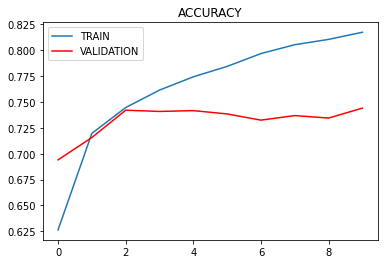

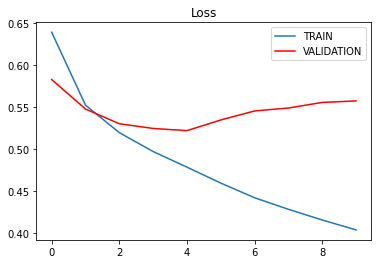

In [68]:
import numpy as np
import matplotlib.pyplot as plt

epoch_axis = np.arange(0, object_epoch) #x축=epoch, y축=정확도

plt.title('ACCURACY')
plt.plot(epoch_axis, [info['accuracy'] for info in train_info], epoch_axis, [info['accuracy'] for info in validation_info], 'r-')
plt.legend(['TRAIN', 'VALIDATION'])
plt.show()

plt.title('Loss')
plt.plot(epoch_axis, [info['loss'] for info in train_info], epoch_axis, [info['loss'] for info in validation_info], 'r-')
plt.legend(['TRAIN', 'VALIDATION'])
plt.show()


# Network Testing

In [70]:
import torch

saved_path = './ClassificationNetwork/best_model.tar'
state_dict = torch.load(saved_path)

print(state_dict.keys())
print(state_dict['memo'])
print(state_dict['accuracy'])

net = ClassificationModel().cuda()
net.load_state_dict(state_dict['model_weight'], strict=True)

accuracy, loss = inference_1epoch(test_dataloader)
print(accuracy)

dict_keys(['memo', 'accuracy', 'model_weight'])
Classification Model!!!
0.744



0.734


# Denoising Data Loader

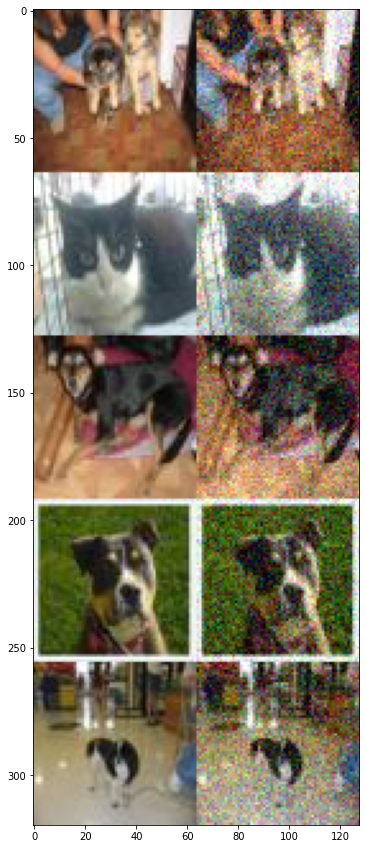

In [71]:
import torch
import torch.utils.data as data
import os
import matplotlib.pyplot as plt
import numpy as np

class NoiseImageLoader(data.Dataset):
  def __init__(self, root_path):
    super(NoiseImageLoader, self).__init__()

    self.root_path = root_path
    self.examples = os.listdir(self.root_path)

  def __len__(self):
    return len(self.examples)

  def __getitem__(self, idx):
    clean_img = plt.imread(self.root_path + '/' + self.examples[idx]) / 255. # 0~1    
    
    # np.clip(x, 0, 1) -> 0과 1사이로 입력을 제한
    # np.random.normal(mean=0, std=0.1) -> 평균이 0이고 표준편차가 0.1인 가우시안 노이즈 생성
    noise_img = np.clip(clean_img + np.random.normal(0, 0.1, (64,64,3)),a_min=0, a_max=1)
    
    return noise_img.transpose(2,0,1).astype('float32'), clean_img.transpose(2,0,1).astype('float32')

train_root = './train'
test_root = './test'
validation_root = './val'

train_examples = NoiseImageLoader(train_root) # name change
validation_examples = NoiseImageLoader(validation_root)
test_examples = NoiseImageLoader(test_root)

train_dataloader = data.DataLoader(train_examples, batch_size=10, shuffle=False)
validation_dataloader = data.DataLoader(validation_examples, batch_size=5, shuffle=False) #batch사이즈가 작으면 트레이닝 오래걸림. 
test_dataloader = data.DataLoader(test_examples, batch_size=1, shuffle=False) #test는 배치사이즈 1로 설정. 


def visualize(samples, samples_num=5):
  samples = [s.detach().cpu() for s in samples]

  # 분리되어있는 이미지를 하나의 이미지로 이어붙이는 코드 (외울 필요 없음)
  visualization_image = torch.cat(samples, dim=3) # [BATCH, CHANNEL, HEIGHT, WIDTH]
  visualization_image = torch.cat([visualization_image[i] for i in range(samples_num)], dim=1) # [ CHANNEL, HEIGHT, WIDTH]]

  plt.figure(figsize=(15,15))
  plt.imshow(visualization_image.permute(1,2,0))
  plt.show()

validation_images = iter(validation_dataloader)
val_noise_imgs, val_clean_imgs = validation_images.next()
visualize([val_clean_imgs, val_noise_imgs])

# Denoising Network

In [72]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class conv_batch_relu(nn.Module):
  def __init__(self):
    super(conv_batch_relu, self).__init__()

    self.conv = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.batch_norm = nn.BatchNorm2d(32)

  def forward(self, x):
    x = self.conv(x)
    x = self.batch_norm(x)
    x = F.relu(x)
    return x

class DenoisingNetwork(nn.Module):
  def __init__(self, D):
    super(DenoisingNetwork, self).__init__()
    self.conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)


    #self.conv_batch_relu()= 을 반복하는거와 같음.(2:32)
    self.sequential_layer = nn.Sequential(
        *[conv_batch_relu() for i in range(D)]   #list를 ,로 분리하는 거처럼 풀어버림. 
    )

    self.final = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1) #rgb 3개채널로 만들어줌. 

  def forward(self, x):
    x = F.relu(self.conv(x))
    x = self.sequential_layer(x)
    x = self.final(x)
    return x

net = DenoisingNetwork(5).cuda()
dummy_input = torch.rand(7,3,64,64).cuda()
output = net(dummy_input)

print('input_shape: ', dummy_input.shape, 'output shape: ', output.shape)

print([name for name, weight in net.named_parameters()])
print(net.state_dict().keys())

input_shape:  torch.Size([7, 3, 64, 64]) output shape:  torch.Size([7, 3, 64, 64])
['conv.weight', 'conv.bias', 'sequential_layer.0.conv.weight', 'sequential_layer.0.conv.bias', 'sequential_layer.0.batch_norm.weight', 'sequential_layer.0.batch_norm.bias', 'sequential_layer.1.conv.weight', 'sequential_layer.1.conv.bias', 'sequential_layer.1.batch_norm.weight', 'sequential_layer.1.batch_norm.bias', 'sequential_layer.2.conv.weight', 'sequential_layer.2.conv.bias', 'sequential_layer.2.batch_norm.weight', 'sequential_layer.2.batch_norm.bias', 'sequential_layer.3.conv.weight', 'sequential_layer.3.conv.bias', 'sequential_layer.3.batch_norm.weight', 'sequential_layer.3.batch_norm.bias', 'sequential_layer.4.conv.weight', 'sequential_layer.4.conv.bias', 'sequential_layer.4.batch_norm.weight', 'sequential_layer.4.batch_norm.bias', 'final.weight', 'final.bias']
odict_keys(['conv.weight', 'conv.bias', 'sequential_layer.0.conv.weight', 'sequential_layer.0.conv.bias', 'sequential_layer.0.batch_norm.w

# Denoising Network Training

In [73]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import os
from tqdm.notebook import tqdm

D = 3
net = DenoisingNetwork(D).cuda() # -> GPGPU
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

object_epoch = 3

train_info = []
validation_info = []

save_path = './DenoisingModel/'
os.makedirs(save_path, exist_ok=True)

print('Training Start!!!!')

#논문에서 R=Y-x 인데, R은 노이즈가 돼서 해당 노이즈를 추론. 

def inference(noise_img):
  net.eval() #필수 

  noise_img = noise_img.float().cuda()
  residual = net(noise_img)

  return torch.clamp(noise_img - residual,min=0, max=1)


def train_1epoch(dataloader):
  total_loss = 0
  iteration = 0

  net.train()
  
  for sample in tqdm(dataloader): #여기선 squeeze() 필요 없음. 
    noise_img, clean_img = sample
    noise_img = noise_img.float().cuda()
    clean_img = clean_img.float().cuda()

    optimizer.zero_grad()
    residual = net(noise_img) # [BATCH, 1] -> [BATCH]

    # ---------------------------------------
    loss = torch.pow(residual - (noise_img - clean_img) ,2).mean() / 2
    loss.backward()
    optimizer.step()

    # detach(): Tensor 기울기 계산 그래프에서 제거
    # cpu()   : GPU memory에 있는 정보를 CPU로 전환
    total_loss += loss.detach().cpu()
    iteration += 1

  total_loss = total_loss/iteration
  
  return total_loss

for epoch in range(object_epoch):
  # Training 1 epoch
  print('Training start epoch {}'.format(epoch))
  loss = train_1epoch(train_dataloader)
  train_info.append({'loss':loss})
  print('[Training] EPOCH {} finish. loss: {}'.format(epoch, loss))

  # Validation 1 Epoch
  visualize([val_clean_imgs, val_noise_imgs, inference(val_noise_imgs)])
  
  # Model Save
  torch.save({
      'model_weight': net.state_dict(),
      'D': D
  }, save_path + '/best_model.tar')

  validation_info.append({'loss':loss})
  print('[VALIDATION] EPOCH {} finish. loss: {}'.format(epoch, loss))
  print('-------------------------------------------------')
print('FINISH!!!')

Output hidden; open in https://colab.research.google.com to view.

# Network Testing

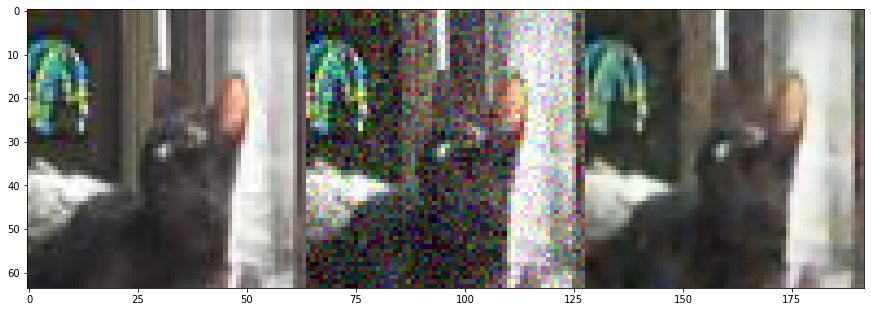

In [ ]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

saved_path = './DenoisingModel/best_model.tar'

state_dict = torch.load(saved_path)

print(state_dict.keys())

net = DenoisingNetwork(3).cuda()
net.load_state_dict(state_dict['model_weight'], strict=True)

for sample in test_dataloader:
  noise_img, clean_img = sample
  noise_img = noise_img.float().cuda()

  residual = net(noise_img)
  outputs = torch.clamp(noise_img - residual,min=0,max=1)

  visualize([clean_img, noise_img, outputs], 1)
  plt.pause(2.0)
  clear_output(wait=True)